# Import necessary libraries

In [16]:
import matplotlib.pyplot as plt
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator,
    AutoModel,
    T5Tokenizer,
    T5ForConditionalGeneration,
)
from datasets import load_dataset
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm
import collections
from sklearn.metrics.pairwise import cosine_similarity
import evaluate  # Import the evaluate package
import gradio as gr  # Gradio for UI

# Device Configuration (GPU/CPU)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Load Dataset (SQuAD v2.0)

In [27]:
# Load the SQuAD v2.0 dataset for training and validation
squad_v2 = load_dataset('squad_v2')

# Limit the dataset for development purposes (feel free to expand)
train_dataset = squad_v2['train'].select(range(1000))
validation_dataset = squad_v2['validation'].select(range(100))


# Define the retrieve function for RAG document retrieval

In [19]:
# Simulate a corpus of documents from the dataset
corpus = list(set(train_dataset['context'] + validation_dataset['context']))

# Chunk documents into passages (e.g., every 100 words)
passages = []
for doc in corpus:
    words = doc.split()
    for i in range(0, len(words), 100):
        chunk = ' '.join(words[i:i+100])
        passages.append(chunk)

# Load a model to embed the documents for retrieval (e.g., MiniLM)
retriever_model_name = 'sentence-transformers/all-MiniLM-L6-v2'
retriever_tokenizer = AutoTokenizer.from_pretrained(retriever_model_name)
retriever_model = AutoModel.from_pretrained(retriever_model_name).to(device)

# Function to get embeddings for the passages
def get_embeddings(texts):
    inputs = retriever_tokenizer(
        texts, padding=True, truncation=True, return_tensors='pt'
    ).to(device)
    with torch.no_grad():
        outputs = retriever_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

# Process passages in batches to reduce memory usage
batch_size = 32  # Adjust based on your GPU memory
passage_embeddings = []

# Get embeddings for all passages
for i in range(0, len(passages), batch_size):
    batch = passages[i:i+batch_size]
    batch_embeddings = get_embeddings(batch)
    passage_embeddings.extend(batch_embeddings)

# Convert the list of embeddings to a NumPy array for easy similarity calculation
passage_embeddings = np.array(passage_embeddings)

# Define the retrieve function to return top k passages
def retrieve(query, k=5):
    query_embedding = get_embeddings([query])[0]
    similarities = cosine_similarity([query_embedding], passage_embeddings)[0]
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    retrieved_passages = [passages[i] for i in top_k_indices]
    return retrieved_passages

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Helper Functions for Data Preprocessing

In [20]:
# Function to prepare training features
def prepare_train_features(examples, tokenizer, max_length=384, doc_stride=128):
    tokenized_examples = tokenizer(
        examples['question'],
        examples['context'],
        truncation='only_second',
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding='max_length',
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples['input_ids'][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized_examples.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)

                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

# Function to prepare validation features
def prepare_validation_features(examples, tokenizer, max_length=384, doc_stride=128):
    tokenized_examples = tokenizer(
        examples['question'],
        examples['context'],
        truncation='only_second',
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding='max_length',
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        sequence_ids = tokenized_examples.sequence_ids(i)
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == 1 else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

# Post-processing Predictions for SQuAD

In [21]:
def postprocess_qa_predictions(
    examples, features, raw_predictions, tokenizer, n_best_size=20, max_answer_length=30
):
    all_start_logits, all_end_logits = raw_predictions
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[feature["example_id"]].append(i)

    predictions = collections.OrderedDict()

    print("Post-processing predictions...")
    for example_index, example_id in enumerate(tqdm(examples["id"])):
        example = examples[example_index]
        feature_indices = features_per_example[example_id]

        min_null_score = None
        valid_answers = []

        context = example["context"]
        for feature_index in feature_indices:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            offset_mapping = features[feature_index]["offset_mapping"]
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)

            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score > feature_null_score:
                min_null_score = feature_null_score

            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                        or end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    answer_text = context[start_char:end_char]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": answer_text,
                        }
                    )
        if valid_answers:
            best_answer = max(valid_answers, key=lambda x: x["score"])
        else:
            best_answer = {"text": "", "score": 0.0}

        predictions[example_id] = best_answer["text"]

    return predictions


# Compute Evaluation Metrics (EM, F1) using Huggingface `evaluate` library

In [22]:
# Section 6: Compute Evaluation Metrics (EM, F1) using Huggingface `evaluate` library

def compute_metrics(trainer, tokenizer, examples, features):
    raw_predictions = trainer.predict(features)
    final_predictions = postprocess_qa_predictions(
        examples, features, raw_predictions.predictions, tokenizer
    )
    metric = evaluate.load('squad_v2')
    formatted_predictions = [
        {"id": k, "prediction_text": v, "no_answer_probability": 0.0}
        for k, v in final_predictions.items()
    ]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    metrics = metric.compute(predictions=formatted_predictions, references=references)
    return metrics

# Plotting the Metrics and Loss

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_metrics(trainer_state):
    """
    Plots the training and evaluation metrics from the trainer state.

    Args:
        trainer_state: The TrainerState object containing the training history.
    """
    # Extract training and evaluation metrics
    metrics = trainer_state.log_history
    train_loss = [log['loss'] for log in metrics if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in metrics if 'eval_loss' in log]
    epochs = range(1, len(train_loss) + 1)  # Generate epochs based on train_loss length

    # Ensure epochs, train_loss, and eval_loss have the same length
    min_len = min(len(epochs), len(train_loss), len(eval_loss))
    epochs = epochs[:min_len]
    train_loss = train_loss[:min_len]
    eval_loss = eval_loss[:min_len]

    # Create a figure and axes for the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Plot training and evaluation loss
    ax.plot(epochs, train_loss, label='Train Loss')
    ax.plot(epochs, eval_loss, label='Eval Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Evaluation Loss')
    ax.legend()

    # Display the plot
    plt.show()


# RAG Document Retrieval and Relevancy Metrics

In [24]:
# Section 8: RAG Document Retrieval and Relevancy Metrics

def compute_retrieval_metrics(queries, k=5):
    relevant_counts = []
    for query in queries:
        retrieved_passages = retrieve(query, k)
        relevant_count = sum([1 for passage in retrieved_passages if query in passage])
        relevant_counts.append(relevant_count)

    plt.figure(figsize=(8, 5))
    plt.plot(range(len(queries)), relevant_counts, marker='o', label="Relevant Documents Retrieved")
    plt.xlabel("Query Index")
    plt.ylabel("Relevant Documents")
    plt.title("RAG Document Retrieval Relevancy")
    plt.legend()
    plt.show()



# Section 9: Gradio UI for Multi-turn Conversations

In [25]:
# Gradio UI for Multi-turn Conversations

def gradio_ui(model, tokenizer):
    conversation = []

    def chat(user_input):
        nonlocal conversation
        answer = rag_qa(user_input)
        conversation.append((user_input, answer))
        chat_history = "\n".join([f"User: {x[0]}\nBot: {x[1]}" for x in conversation])
        return chat_history

    def reset_conversation():
        nonlocal conversation
        conversation = []
        return ""

    with gr.Blocks() as ui:
        chatbot = gr.Textbox(label="Multi-turn Conversation", placeholder="Ask something...")
        output = gr.Textbox(label="Chat History", interactive=False)
        submit = gr.Button("Send")
        submit.click(chat, inputs=chatbot, outputs=output)

        reset_button = gr.Button("Reset Conversation")
        reset_button.click(reset_conversation, outputs=output)

    return ui



# Section 10: Train, Evaluate, and Launch the Gradio UI


Training and evaluating model: albert-base-v2


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.840900,No log


Post-processing predictions...


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluation Metrics:
Exact Match: 33.00
F1 Score: 35.46


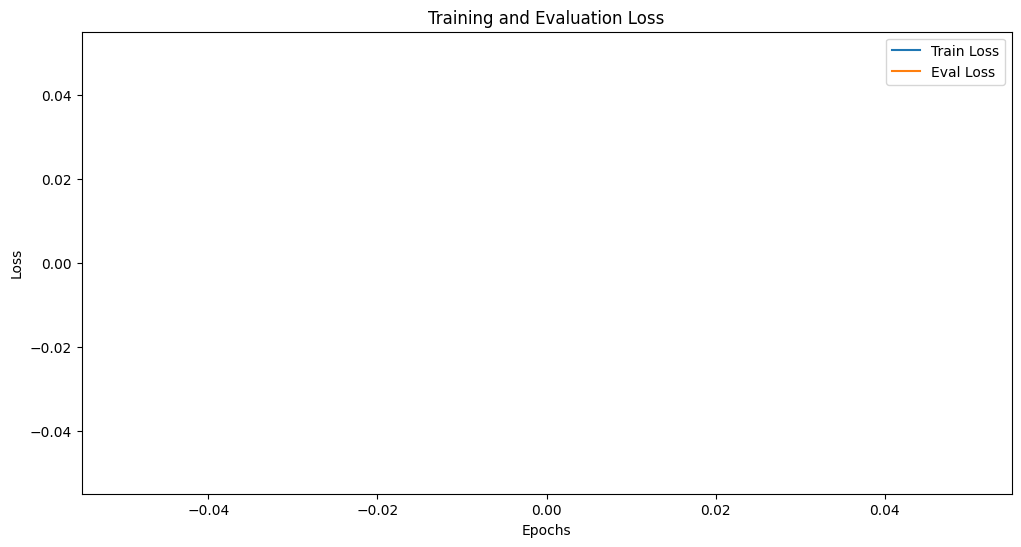

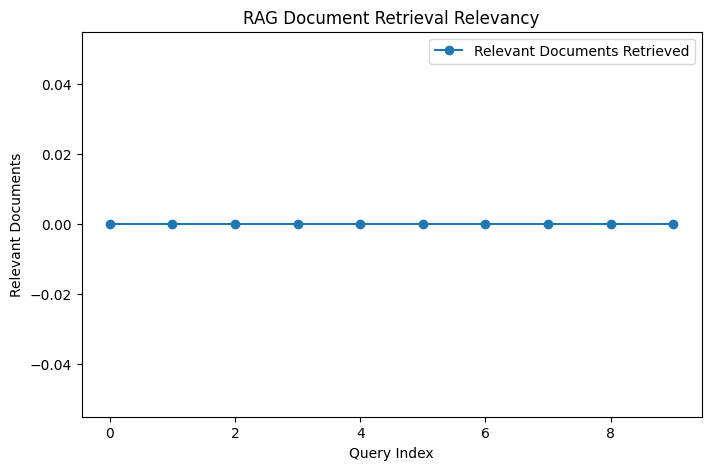

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dcbf2b4f989da11691.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [28]:
# Train, Evaluate, and Launch the Gradio UI

def train_and_evaluate(model_name):
    print(f"\nTraining and evaluating model: {model_name}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)

    tokenized_train = train_dataset.map(
        lambda x: prepare_train_features(x, tokenizer),
        batched=True,
        remove_columns=train_dataset.column_names,
    )

    tokenized_validation = validation_dataset.map(
        lambda x: prepare_validation_features(x, tokenizer),
        batched=True,
        remove_columns=validation_dataset.column_names,
    )

    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        evaluation_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=1,
        weight_decay=0.01,
        logging_dir=f'./logs/{model_name}',
        logging_steps=10,
        save_total_limit=1,
        push_to_hub=False,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_validation,
        tokenizer=tokenizer,
        data_collator=default_data_collator,
    )

    trainer.train()

    metrics = compute_metrics(trainer, tokenizer, validation_dataset, tokenized_validation)
    print("Evaluation Metrics:")
    print(f"Exact Match: {metrics['exact']:.2f}")
    print(f"F1 Score: {metrics['f1']:.2f}")

    plot_training_metrics(trainer.state)

    return model, tokenizer, metrics

# Example usage:
if __name__ == "__main__":
    model_name = 'albert-base-v2'
    model, tokenizer, metrics = train_and_evaluate(model_name)

    test_queries = [validation_dataset[i]['question'] for i in range(10)]
    compute_retrieval_metrics(test_queries)

    ui = gradio_ui(model, tokenizer)
    ui.launch()